<a href="https://colab.research.google.com/github/SridharanS2001/HTSMA-ML-DL-codes/blob/main/Phasefieldmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 50


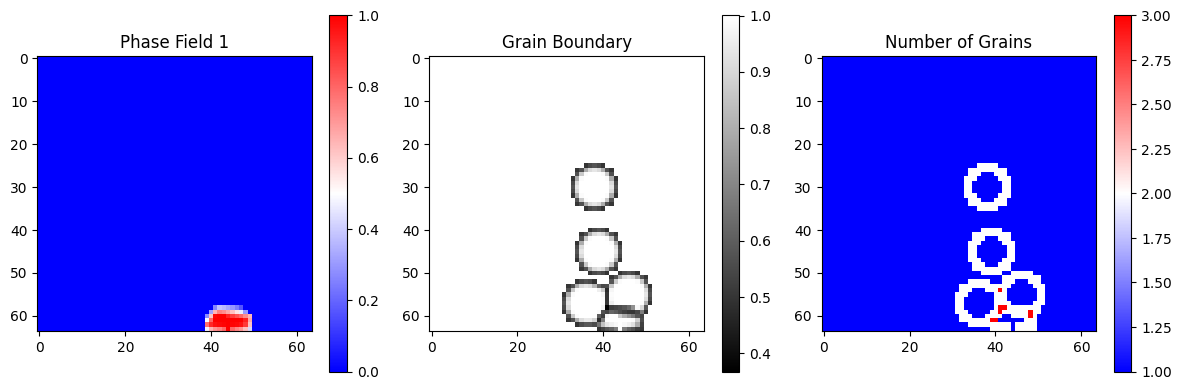

Step 100


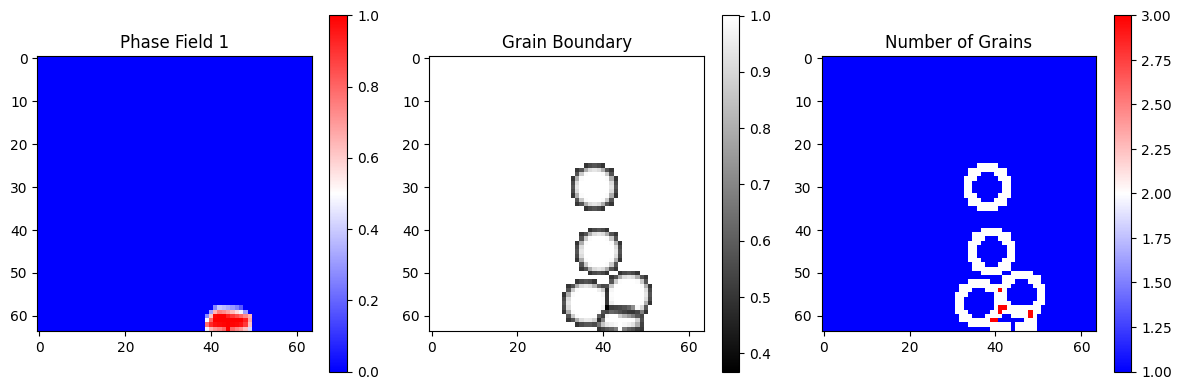

Step 150


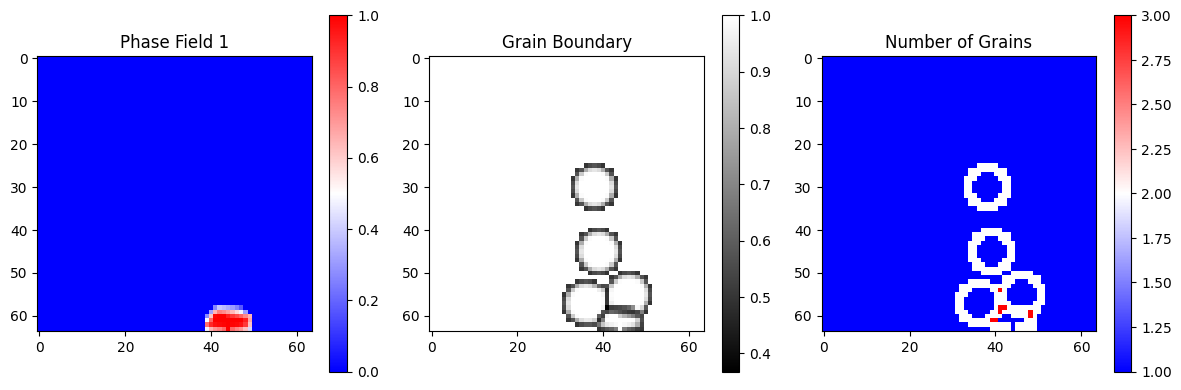

Step 200


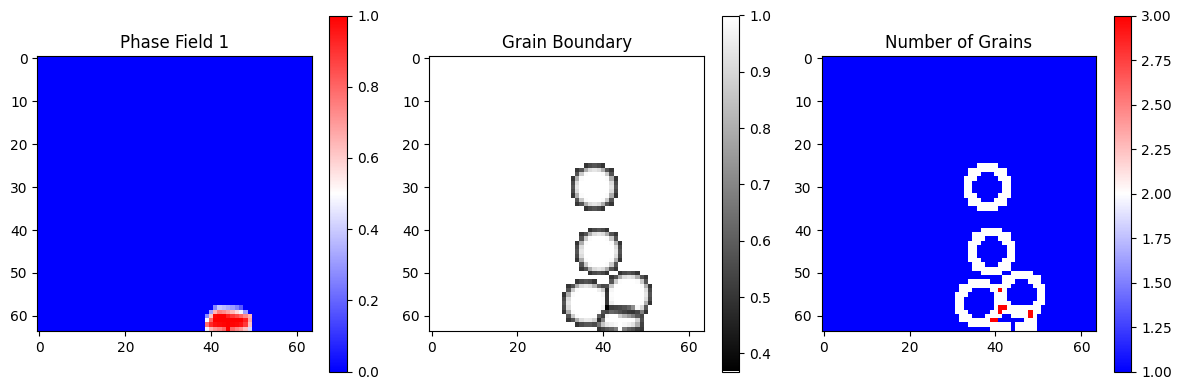

Step 250


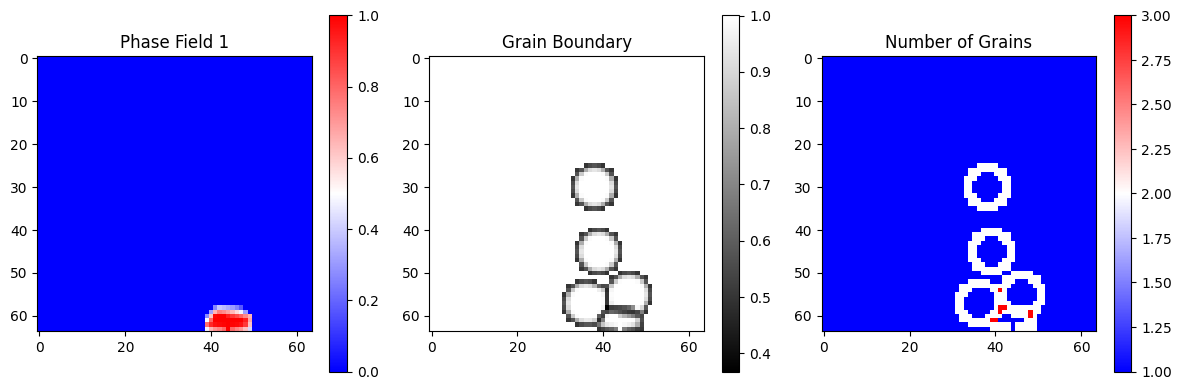

Step 300


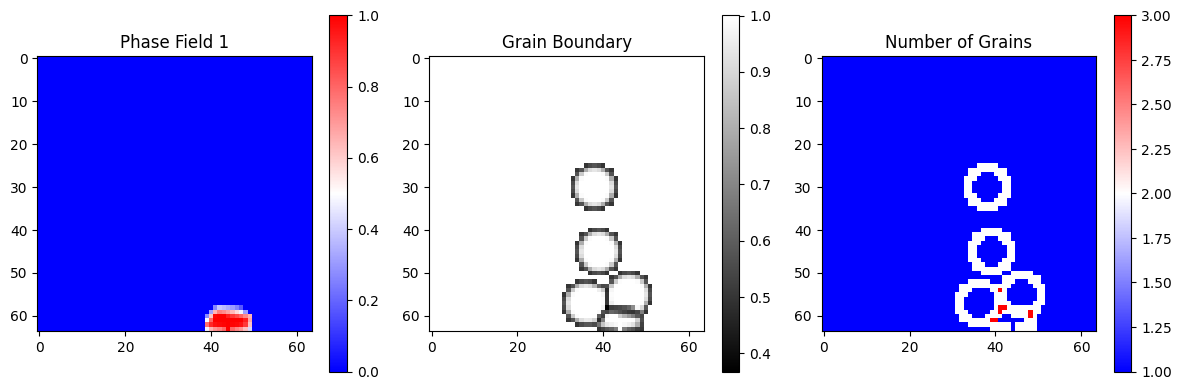

Step 350


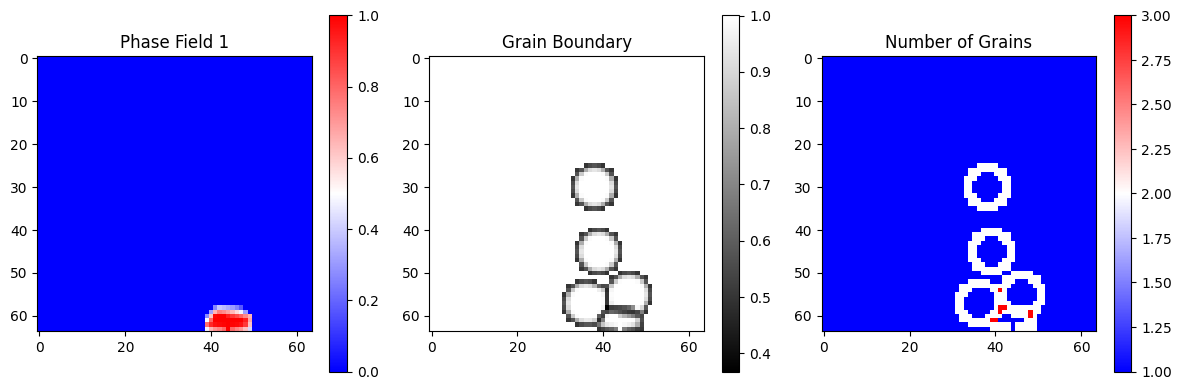

Step 400


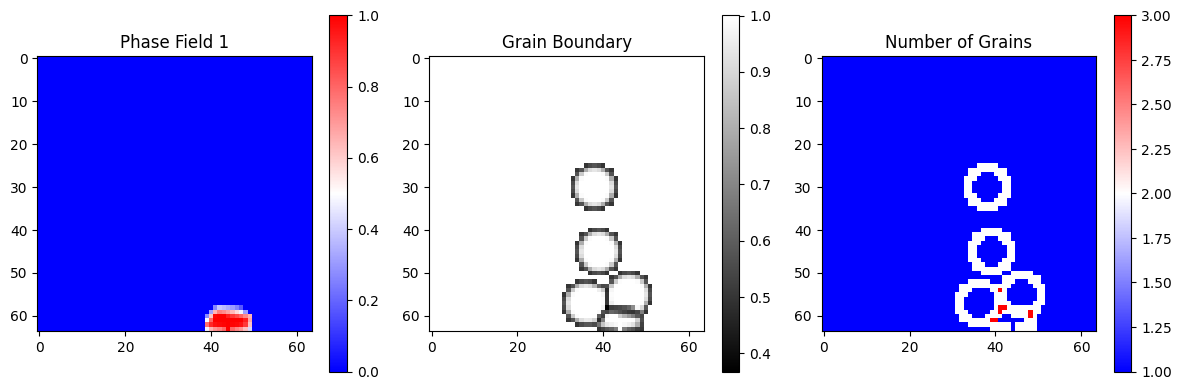

Step 450


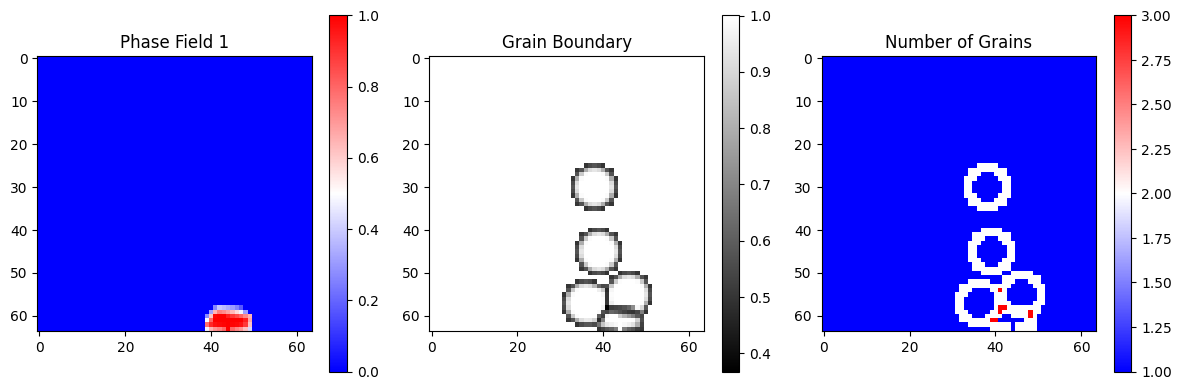

Step 500


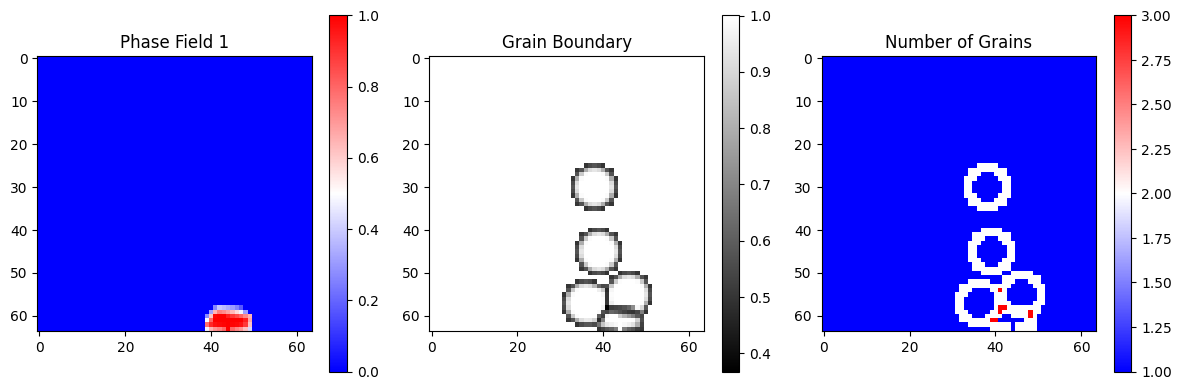

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand

# Set parameters and physical values
nx, ny = 64, 64  # Computational grid size
number_of_grain = 6  # Number of grains
dx, dy = 0.5e-6, 0.5e-6  # Grid spacing [m]
dt = 0.05  # Time increment [s]
nsteps = 500  # Total number of time steps
pi = np.pi
sigma = 1.0  # Grain boundary energy [J/m²]
delta = 6.0 * dx  # Thickness of diffuse interface
eee = 3.0e6  # Magnitude of driving force

# Calculate phase-field parameters
aaa = 2.0 / pi * np.sqrt(2.0 * delta * sigma)  # Gradient energy coefficient
www = 4.0 * sigma / delta  # Height of double-obstacle potential
pmobi = pi * pi / (8.0 * delta) * 3.0e-13  # Mobility of phase-field

# Declare arrays
phi = np.zeros((number_of_grain, nx, ny))  # Phase-field variables
phi_new = np.zeros((number_of_grain, nx, ny))
mf = np.zeros((15, nx, ny), dtype=int)  # Grain IDs
nf = np.zeros((nx, ny), dtype=int)  # Number of grains per grid
wij = np.zeros((number_of_grain, number_of_grain))  # Double-obstacle potential
aij = np.zeros((number_of_grain, number_of_grain))  # Gradient energy coefficient
mij = np.zeros((number_of_grain, number_of_grain))  # Phase-field mobility
eij = np.zeros((number_of_grain, number_of_grain))  # Driving force
gb = np.zeros((nx, ny))  # Grain boundary for visualization

# Initialize phase-field parameters and driving force
for i in range(number_of_grain):
    for j in range(number_of_grain):
        wij[i, j] = www
        aij[i, j] = aaa
        mij[i, j] = pmobi
        eij[i, j] = 0.0
        if i == j:
            wij[i, j] = 0.0
            aij[i, j] = 0.0
            mij[i, j] = 0.0
        if i == 0 or j == 0:
            eij[i, j] = eee
        if i < j:
            eij[i, j] = -eij[i, j]

# Set initial distribution of phase-field variables
phi[0, :, :] = 1.0
nf[:, :] = 1
r_nuclei = 3.0 * dx

for i in range(1, number_of_grain):
    x_nuclei = int(rand() * nx)
    y_nuclei = int(rand() * ny)
    for m in range(ny):
        for l in range(nx):
            r = np.sqrt((l * dx - x_nuclei * dx)**2 + (m * dy - y_nuclei * dy)**2) - r_nuclei
            tmp = np.sqrt(2.0 * www) / aaa * r
            phi_tmp = 0.5 * (1.0 - np.sin(tmp))
            if tmp >= pi / 2.0:
                phi_tmp = 0.0
            if tmp <= -pi / 2.0:
                phi_tmp = 1.0
                nf[l, m] -= 1
            if phi_tmp > 0:
                nf_tmp = nf[l, m] + 1
                nf[l, m] = nf_tmp
                mf[nf_tmp, l, m] = i
                phi[i, l, m] = phi_tmp
                phi[0, l, m] -= phi[i, l, m]

for m in range(ny):
    for l in range(nx):
        gb[l, m] = np.sum(phi[:, l, m] * phi[:, l, m])

# Function to update grain ID and number of grains
def update_nfmf(phi, mf, nf):
    for m in range(ny):
        for l in range(nx):
            n = 0
            for i in range(number_of_grain):
                if phi[i, l, m] > 0.0:
                    n += 1
                    mf[n - 1, l, m] = i
            nf[l, m] = n

# Function to update phase-field variables
def update_phasefield(phi, phi_new, mf, nf, eij):
    for m in range(ny):
        for l in range(nx):
            for n1 in range(nf[l, m]):
                i = mf[n1, l, m]
                dpi = 0.0
                for n2 in range(nf[l, m]):
                    j = mf[n2, l, m]
                    ppp = 0.0
                    for n3 in range(nf[l, m]):
                        k = mf[n3, l, m]
                        ppp += (wij[i, k] - wij[j, k]) * phi[k, l, m] + \
                               0.5 * (aij[i, k]**2 - aij[j, k]**2) * \
                               (phi[k, (l + 1) % nx, m] + phi[k, (l - 1) % nx, m] +
                                phi[k, l, (m + 1) % ny] + phi[k, l, (m - 1) % ny] - 4.0 * phi[k, l, m]) / dx / dx
                        phii_phij = phi[i, l, m] * phi[j, l, m]
                        dpi -= 2.0 * mij[i, j] / float(nf[l, m]) * (ppp - 8.0 / pi * np.sqrt(phii_phij) * eij[i, j])
                phi_new[i, l, m] = phi[i, l, m] + dpi * dt

    phi_new = np.clip(phi_new, 0.0, 1.0)
    for m in range(ny):
        for l in range(nx):
            phi[:, l, m] = phi_new[:, l, m] / np.sum(phi_new[:, l, m])

# Run simulation and plot results
for nstep in range(1, nsteps + 1):
    update_nfmf(phi, mf, nf)
    update_phasefield(phi, phi_new, mf, nf, eij)

    if nstep % 50 == 0:
        print(f"Step {nstep}")
        for m in range(ny):
            for l in range(nx):
                gb[l, m] = np.sum(phi[:, l, m] * phi[:, l, m])

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(phi[1, :, :], cmap='bwr')
        plt.title('Phase Field 1')
        plt.colorbar()

        plt.subplot(1, 3, 2)
        plt.imshow(gb, cmap='gray')
        plt.title('Grain Boundary')
        plt.colorbar()

        plt.subplot(1, 3, 3)
        plt.imshow(nf, cmap='bwr')
        plt.title('Number of Grains')
        plt.colorbar()

        plt.tight_layout()
        plt.show()


nstep =  50


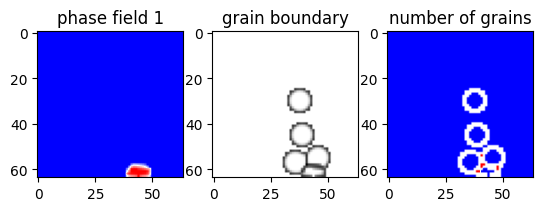

nstep =  100


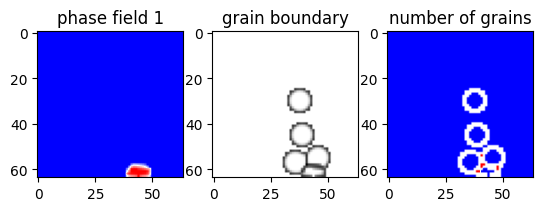

nstep =  150


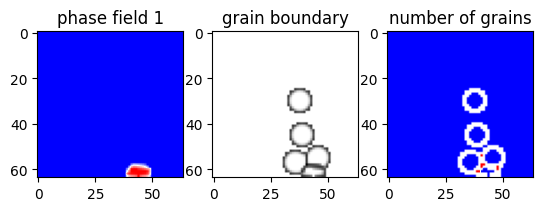

KeyboardInterrupt: 

In [2]:
for nstep in range(1,nsteps+1):
    update_nfmf(phi,mf,nf)
    update_phasefield(phi,phi_new,mf,nf,eij)

    if nstep % 50 == 0:
        print('nstep = ', nstep)
        for m in range(0,ny):
            for l in range(0,nx):
                gb[l,m] = np.sum(phi[:,l,m]*phi[:,l,m])

        plt.subplot(1,3, 1)
        plt.imshow(phi[1,:,:], cmap='bwr')
        plt.title('phase field 1')
        #plt.colorbar()
        plt.subplot(1,3, 2)
        plt.imshow(gb, cmap='gray')
        plt.title('grain boundary')
        #plt.colorbar()
        plt.subplot(1,3, 3)
        plt.imshow(nf, cmap='bwr')
        plt.title('number of grains')
        #plt.colorbar()
        plt.show()

In [3]:
import numpy as np
from numpy.random import *
import matplotlib.pyplot as plt
import math

In [4]:
nx = 64 # number of computational grids along x direction
ny = nx # number of computational grids along y direction
number_of_grain = 6 # total number of grains: N
dx, dy = 0.5e-6, 0.5e-6 # spacing of computational grids [m]
dt = 0.05 # time increment [s]
nsteps = 500# total number of time-steps
pi = np.pi
sigma = 1.0 # grain boundary energy [J/m2]
delta = 6.0 * dx # thickness of diffuse interface
eee = 3.0e+6 # magnitude of driving force

In [5]:
aaa = 2.0 / pi * np.sqrt(2.0*delta*sigma) # gradient energy coefficient
www = 4.0 * sigma/delta # height of double-obstacle potential
pmobi = pi*pi/(8.*delta)*3.0e-13 # mobility of phase-field

In [6]:
wij = np.zeros((number_of_grain,number_of_grain)) # array for the height of double-obstacle potential
aij = np.zeros((number_of_grain,number_of_grain)) # array for the gradient energy coefficient
mij = np.zeros((number_of_grain,number_of_grain)) # array for the mobility of phase-field

In [7]:
phi = np.zeros((number_of_grain,nx,ny)) # phase-field variable at time t
phi_new = np.zeros((number_of_grain,nx,ny)) # phase-field variable at time t+dt
mf = np.zeros((15,nx,ny),dtype = int) # array for saving the grain IDs at the computational grid [i, j]
nf = np.zeros((nx,ny),dtype = int) # array for saving the number of grains at the computational grid [i, j]

In [8]:
eij = np.zeros((number_of_grain,number_of_grain)) # arrays for saving the magnitude of driving foce of grain boundary migration
gb = np.zeros((nx,ny)) # array for visuallizing the grain boundary

In [9]:
for i in range(0,number_of_grain):
    for j in range(0,number_of_grain):
        wij[i,j] = www
        aij[i,j] = aaa
        mij[i,j] = pmobi
        eij[i,j] = 0.0
        if i == j:
            wij[i,j] = 0.0
            aij[i,j] = 0.0
            mij[i,j] = 0.0
        if i == 0 or j == 0:
            eij[i,j] = eee
        if i < j:
            eij[i,j] = -eij[i,j]

In [10]:
def update_nfmf(phi,mf,nf):
    for m in range(ny):
        for l in range(nx):
            l_p = l + 1
            l_m = l - 1
            m_p = m + 1
            m_m = m - 1
            if l_p > nx-1:
                l_p = l_p - nx
            if l_m < 0:
                l_m = l_m + nx
            if m_p > ny-1:
                m_p = m_p - ny
            if m_m < 0:
                m_m = m_m + ny
            n = 0
            for i in range(number_of_grain):
                if phi[i,l,m] > 0.0 or (phi[i,l,m] == 0.0 and phi[i,l_p,m] > 0.0 or phi[i,l_m,m] > 0.0 or phi[i,l,m_p] > 0.0 or phi[i,l,m_m] > 0.0):
                    n += 1
                    mf[n-1,l,m] = i
            nf[l,m] = n

In [11]:
def update_phasefield(phi,phi_new,mf,nf,eij):
    for m in range(ny):
        for l in range(nx):
            l_p = l + 1
            l_m = l - 1
            m_p = m + 1
            m_m = m - 1
            if l_p > nx-1:
                l_p = l_p - nx
            if l_m < 0:
                l_m = l_m + nx
            if m_p > ny-1:
                m_p = m_p - ny
            if m_m < 0:
                m_m = m_m + ny
            for n1 in range(nf[l,m]):
                i = mf[n1,l,m]
                dpi = 0.0
                for n2 in range(nf[l,m]):
                    j = mf[n2,l,m]
                    ppp = 0.0
                    for n3 in range(nf[l,m]):
                        k = mf[n3,l,m]
                        ppp += (wij[i,k]-wij[j,k])*phi[k,l,m]+0.5*(aij[i,k]**2 - aij[j,k]**2)*(phi[k,l_p,m]+phi[k,l_m,m]+phi[k,l,m_p]+phi[k,l,m_m]-4.0*phi[k,l,m])/dx/dx
#                    dpi = dpi - 2.0 * mij[i,j] / float(nf[l,m]) * ppp
                        phii_phij = phi[i,l,m]*phi[j,l,m]
                        dpi = dpi - 2.0 * mij[i,j] / float(nf[l,m]) * (ppp - 8./pi*np.sqrt(phii_phij)*eij[i,j])
                phi_new[i,l,m] = phi[i,l,m] + dpi *dt

    phi_new = np.where(phi_new <= 0.0,0.0,phi_new)
    phi_new = np.where(phi_new >= 1.0,1.0,phi_new)

    for m in range(ny):
        for l in range(nx):
            a = np.sum(phi_new[:,l,m])
            phi[:,l,m] = phi_new[:,l,m] / a

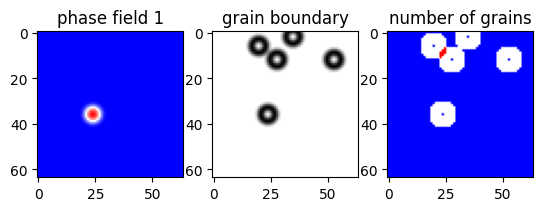

In [12]:
phi = np.zeros((number_of_grain,nx,ny))
phi_new = np.zeros((number_of_grain,nx,ny))
mf = np.zeros((15,nx,ny),dtype = int)
nf = np.zeros((nx,ny),dtype = int)

phi[0,:,:] = 1.0
nf[:,:] = 1
r_nuclei = 3.*dx # radius of the initial grains

for i in range(1,number_of_grain):
    x_nuclei = int(rand()*nx)
    y_nuclei = int(rand()*ny)
    for m in range(ny):
        for l in range(nx):
            if l > nx-1:
                l = l - nx
            if l < 0:
                l = l + nx
            if m > ny-1:
                m = m - ny
            if m < 0:
                m = m + ny
            r = np.sqrt( (l *dx-x_nuclei*dx)**2 +(m*dy-y_nuclei*dy)**2 ) - r_nuclei
            tmp = np.sqrt(2.*www)/aaa*r
            phi_tmp = 0.5*(1.-np.sin(tmp))
            if tmp >= pi/2.:
                phi_tmp=0.
            if tmp <= -pi/2.:
                phi_tmp=1.
                nf[l,m] = nf[l,m] -1
            if phi_tmp > 0:
                nf_tmp = nf[l,m]+1
                nf[l,m] = nf_tmp
                mf[nf_tmp,l,m] = i
                phi[i,l,m] = phi_tmp
                phi[0,l,m] = phi[0,l,m]-phi[i,l,m]

for m in range(0,ny):
    for l in range(0,nx):
        gb[l,m] = np.sum(phi[:,l,m]*phi[:,l,m])

plt.subplot(1,3, 1)
plt.imshow(phi[1,:,:], cmap='bwr')
plt.title('phase field 1')
#plt.colorbar()
plt.subplot(1,3, 2)
plt.imshow(gb, cmap="gray")
plt.title('grain boundary')
#plt.colorbar()
plt.subplot(1,3, 3)
plt.imshow(nf, cmap='bwr')
plt.title('number of grains')
#plt.colorbar()
plt.show()

nstep =  50


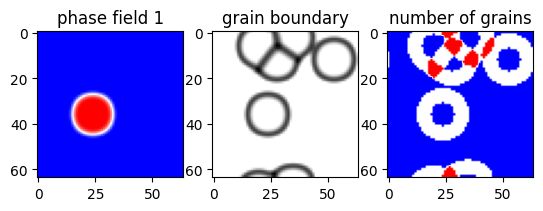

nstep =  100


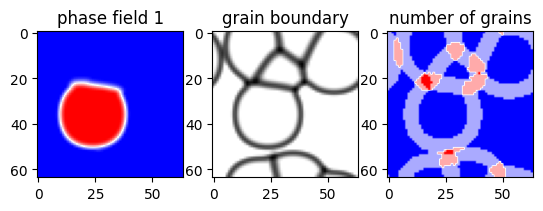

nstep =  150


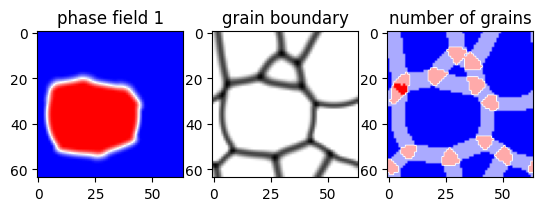

nstep =  200


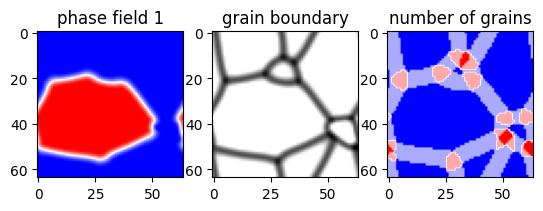

nstep =  250


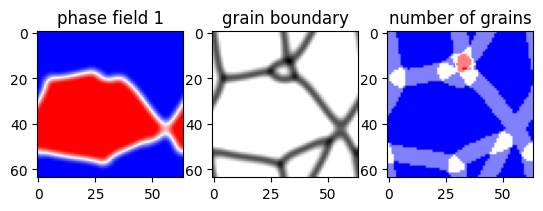

nstep =  300


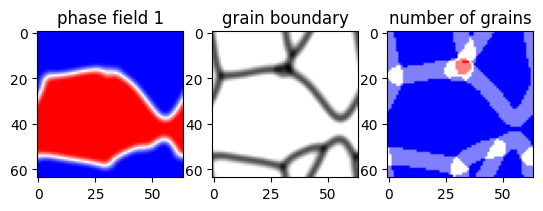

nstep =  350


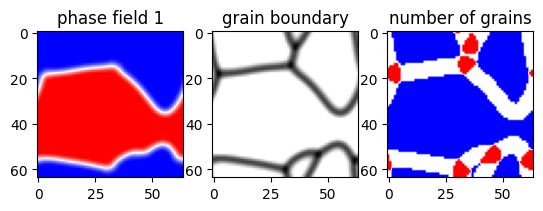

nstep =  400


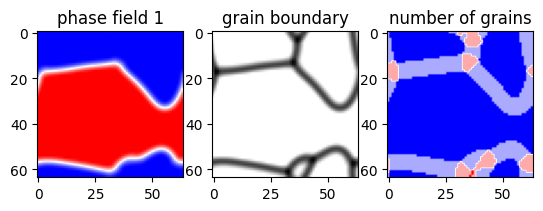

nstep =  450


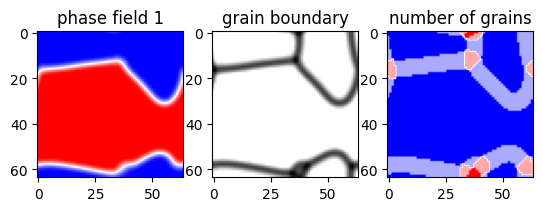

nstep =  500


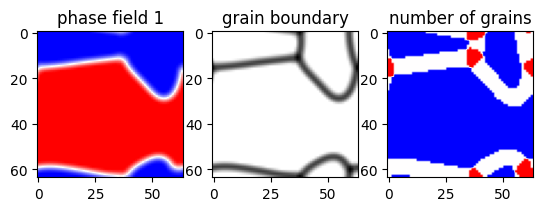

In [13]:
for nstep in range(1,nsteps+1):
    update_nfmf(phi,mf,nf)
    update_phasefield(phi,phi_new,mf,nf,eij)

    if nstep % 50 == 0:
        print('nstep = ', nstep)
        for m in range(0,ny):
            for l in range(0,nx):
                gb[l,m] = np.sum(phi[:,l,m]*phi[:,l,m])

        plt.subplot(1,3, 1)
        plt.imshow(phi[1,:,:], cmap='bwr')
        plt.title('phase field 1')
        #plt.colorbar()
        plt.subplot(1,3, 2)
        plt.imshow(gb, cmap='gray')
        plt.title('grain boundary')
        #plt.colorbar()
        plt.subplot(1,3, 3)
        plt.imshow(nf, cmap='bwr')
        plt.title('number of grains')
        #plt.colorbar()
        plt.show()

In [14]:
from numba import jit
import numpy as np
import random

In [15]:
# set parameters and physical values
nx = 64
ny = nx
nz = nx
number_of_grains = 20
dx = 0.5e-6
dt = 0.1
nsteps = 2000
pi = np.pi
sigma = 1.0
delta = 7.0 * dx
eee = 1.0e+7


In [16]:
# calculate phase-field parameters (a, W, and M^phi)
aaa = 2.0 / pi * np.sqrt(2.0*delta*sigma)
www = 4.0 * sigma/delta
pmobi = 1.0e-7


In [17]:
# declare arrays for phase-field parameters (a_ij, w_ij, and M_ij)
wij = np.zeros((number_of_grains,number_of_grains))
aij = np.zeros((number_of_grains,number_of_grains))
mij = np.zeros((number_of_grains,number_of_grains))

In [18]:
# declair arrays for the phase-field variables, grain ID, and number of grain
phi = np.zeros((number_of_grains,nx,ny,nz))
phi_new = np.zeros((number_of_grains,nx,ny,nz))
mf = np.zeros((15,nx,ny,nz),dtype = int)
nf = np.zeros((nx,ny,nz),dtype = int)

In [19]:
# declair arrays for dirving force
eij = np.zeros((number_of_grains,number_of_grains))

In [20]:
# calculate phase-field parameters (a_ij, w_ij, and M_ij) and driving force
for i in range(0,number_of_grains):
    for j in range(0,number_of_grains):
        wij[i,j] = www
        aij[i,j] = aaa
        mij[i,j] = pmobi
        eij[i,j] = 0.0
        if i == j:
            wij[i,j] = 0.0
            aij[i,j] = 0.0
            mij[i,j] = 0.0
        if i == 1 or j == 1:
            eij[i,j] = eee
        if i < j:
            eij[i,j] = -eij[i,j]

In [21]:
# function for cauclating number of grains and phase-field variables
# this function is accelerated by JIT compiler
@jit
def update(phi,phi_new,mf,nf,eij):
    for k in range(nz):
        for m in range(ny):
            for l in range(nx):
                l_p = l + 1
                l_m = l - 1
                m_p = m + 1
                m_m = m - 1
                k_p = k + 1
                k_m = k - 1
                if l_p > nx-1:
                    l_p = l_p - nx
                if l_m < 0:
                    l_m = l_m + nx
                if m_p > ny-1:
                    m_p = m_p - ny
                if m_m < 0:
                    m_m = m_m + ny
                if k_p > nz-1:
                    k_p = k_p - nz
                if k_m < 0:
                    k_m = k_m + nz
                n = 0
                for i in range(number_of_grains):
                    if phi[i,l,m,k] > 0.0 or (phi[i,l,m,k] == 0.0 and phi[i,l_p,m,k] > 0.0 or phi[i,l_m,m,k] > 0.0 or phi[i,l,m_p,k] > 0.0 or phi[i,l,m_m,k] > 0.0 or phi[i,l,m,k_p] > 0.0 or phi[i,l,m,k_m] > 0.0):
                        n += 1
                        mf[n-1,l,m,k] = i
                        nf[l,m,k] = n

    for n in range(nz):
        for m in range(ny):
            for l in range(nx):
                l_p = l + 1
                l_m = l - 1
                m_p = m + 1
                m_m = m - 1
                n_p = n + 1
                n_m = n - 1
                if l_p > nx-1:
                    l_p = l_p - nx
                if l_m < 0:
                    l_m = l_m + nx
                if m_p > ny-1:
                    m_p = m_p - ny
                if m_m < 0:
                    m_m = m_m + ny
                if n_p > nz-1:
                    n_p = n_p - nz
                if n_m < 0:
                    n_m = n_m + nz
                for n1 in range(nf[l,m,n]):
                    i = mf[n1,l,m,n]
                    dpi = 0.0
                    for n2 in range(nf[l,m,n]):
                        j = mf[n2,l,m,n]
                        ppp = 0.0
                        for n3 in range(nf[l,m,n]):
                             k = mf[n3,l,m,n]
                             ppp += (wij[i,k]-wij[j,k])*phi[k,l,m,n]+0.5*(aij[i,k]**2 - aij[j,k]**2)*(phi[k,l_p,m,n]+phi[k,l_m,m,n]+phi[k,l,m_p,n]+phi[k,l,m_m,n]+phi[k,l,m,n_p]+phi[k,l,m,n_m]-6.0*phi[k,l,m,n])/dx/dx
                        pee = phi[i,l,m,n]*phi[j,l,m,n]
                        dpi = dpi - 2.0 * mij[i,j] / float(nf[l,m,n]) * (ppp - 8.0/pi*np.sqrt(pee)*eij[i,j])
                    phi_new[i,l,m,n] = phi[i,l,m,n] + dpi *dt

    phi_new = np.where(phi_new <= 0.0,0.0,phi_new)
    phi_new = np.where(phi_new >= 1.0,1.0,phi_new)

    for k in range(nz):
        for m in range(ny):
            for l in range(nx):
                a = np.sum(phi_new[:,l,m,k])
                phi[:,l,m,k] = phi_new[:,l,m,k] / a


In [25]:
# Function to generate VTK file for visualization
def output(nstep, phi, nf, mf):
    with open(f'p_3d{nstep}.vtk', 'w') as f:
        f.write('# vtk DataFile Version 3.0 \n')
        f.write(f'p{nstep}.vtk \n')
        f.write('ASCII \n')
        f.write('DATASET STRUCTURED_POINTS \n')
        f.write(f'DIMENSIONS {nx} {ny} {nz} \n')
        f.write('ORIGIN 0.0 0.0 0.0 \n')
        f.write('SPACING 1.0 1.0 1.0 \n')
        f.write(f'POINT_DATA {nx * ny * nz} \n')

        # Write grain boundary data
        f.write('SCALARS grain_boundary float \n')
        f.write('LOOKUP_TABLE default \n')
        for k in range(nz):
            for m in range(ny):
                for l in range(nx):
                    f.write(f'{np.sum(phi[:, l, m, k] * phi[:, l, m, k])} \n')

        # Write grain ID data
        f.write('SCALARS grain_ID int \n')
        f.write('LOOKUP_TABLE default \n')
        for k in range(nz):
            for m in range(ny):
                for l in range(nx):
                    num_grain = 0
                    max_phi = 0.0
                    for n in range(nf[l, m, k]):
                        n1 = mf[n, l, m, k]
                        if phi[n1, l, m, k] > max_phi:
                            max_phi = phi[n1, l, m, k]
                            num_grain = n1
                    f.write(f'{num_grain} \n')

# Initial setup for phase-field variables and others
phi[1, :, :, :] = 1.0
nf[:, :, :] = 1
mf[1, :, :, :] = 1

for i in range(1, number_of_grains):
    center_x = np.random.randint(1, nx)
    center_y = np.random.randint(1, ny)
    center_z = np.random.randint(1, nz)
    print(center_x, center_y, center_z)
    for k in range(nz):
        for m in range(ny):
            for l in range(nx):
                x = (l - center_x) * dx
                y = (m - center_y) * dx
                z = (k - center_z) * dx
                r = np.sqrt(x * x + y * y + z * z)
                if r < 3.0 * dx:
                    nf[l, m, k] = 1
                    mf[1, l, m, k] = i
                    phi[i, l, m, k] = 1.0

# Output initial condition
output(0, phi, nf, mf)

# Main loop for simulation
for nstep in range(1, nsteps + 1):
    update(phi, phi_new, mf, nf, eij)
    if nstep % 100 == 0:
        output(nstep, phi, nf, mf)


3 6 40
41 58 39
48 17 4
26 16 38
13 20 61
49 27 18
54 30 29
24 24 15
34 34 5
39 7 42
18 53 31
31 60 1
16 23 6
5 12 46
30 28 2
48 23 26
53 20 50
3 18 22
32 4 2


KeyboardInterrupt: 